This notebook took the trained model and applied it to the full dataset. It calculated party lean and produced the drawings of the shapefiles used in the final app.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import feather
from datetime import date, datetime
import joblib

In [2]:
data_path = '/Volumes/FileStorage/Insight_data/'
ohio_path = '/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/'

In [ ]:
oh_df=feather.read_dataframe('/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/oh_census_df.feather')

In [ ]:
oh_df[oh_df['PRECINCT_NAME']=='JACKSON A'].groupby(['PRECINCT_NAME','STATE_REPRESENTATIVE_DISTRICT']).sum()

In [ ]:
model = joblib.load('logreg_fulldata_census.joblib')

In [ ]:
features=['PARTY_AFFILIATION','STATE_REPRESENTATIVE_DISTRICT','PRECINCT_NAME','AGE_2020','GENERAL-11/08/2016','RATIO_2020','HC02_EST_VC17','HC02_EST_VC18']
model_features=['AGE_2020','GENERAL-11/08/2016','RATIO_2020','HC02_EST_VC17','HC02_EST_VC18']

In [ ]:
df_X=oh_df.loc[:, features]

In [ ]:
df_X['PARTY_AFFILIATION']=df_X['PARTY_AFFILIATION'].fillna('N')

In [ ]:
df_X.groupby('PARTY_AFFILIATION').size()

In [5]:
N=4563298
D=1338397
G=6775
L=23
R=1916892

tot_p=N+D+G+L+R

In [6]:
tot_p

7825385

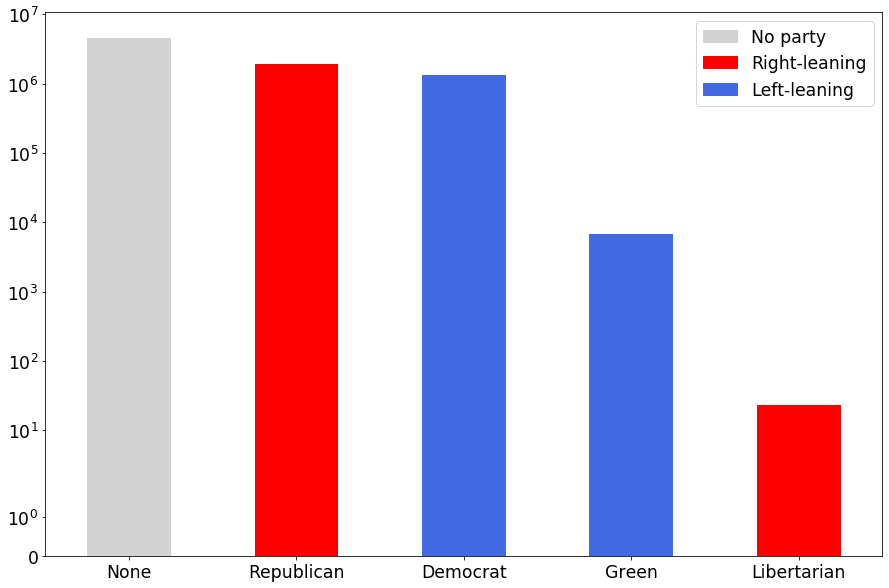

In [21]:
import matplotlib.patches as mpatches
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)


s=pd.Series([N,R,D,G,L],index=['None','Republican','Democrat','Green','Libertarian'])
c=['lightgrey','red','royalblue','royalblue','red']
s.plot(kind='bar',color=c)
plt.xticks(rotation=360)
nopref=mpatches.Patch(color='lightgrey', label='No party')
right=mpatches.Patch(color='red',label='Right-leaning')
left=mpatches.Patch(color='royalblue',label='Left-leaning')
plt.legend(handles=[nopref,right,left])
axes = plt.gca()
plt.yscale('symlog')
plt.show()

In [11]:
df_X_model=oh_df.loc[:, model_features]

NameError: name 'oh_df' is not defined

In [18]:
df_Y_model=model.predict(df_X_model)

In [19]:
df_Y_model.shape

(7825385,)

In [20]:
df_results=df_X
df_results['2020_pred']=df_Y_model

In [21]:
df_results.head()

,PARTY_AFFILIATION,STATE_REPRESENTATIVE_DISTRICT,PRECINCT_NAME,AGE_2020,GENERAL-11/08/2016,RATIO_2020,HC02_EST_VC17,HC02_EST_VC18,2020_pred
0,N,82,PRECINCT ST. MARYS 3A,50,-1,0.057143,90.5,15.7,-1
1,N,53,MONROE 2,45,0,0.257143,94.9,35.4,0
2,N,9,CLEVELAND-02-Q,49,-1,0.000000,78.6,9.9,-1
3,N,65,MIAMI TOWNSHIP X,47,0,0.171429,94.9,46.6,0
4,N,12,CLEVELAND-01-E,45,0,0.333333,85.5,14.0,0


In [22]:
feather.write_dataframe(df_results,'/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/results.feather')
feather.write_dataframe(df_results,'/Users/kristinalooper/WorkArea/insight/results.feather')

In [63]:
df_results = feather.read_dataframe('/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/results.feather')

In [64]:
df_results['2020_pred'].replace(-1, np.nan,inplace=True)
df_results['2020_pred'].replace(0,1,inplace=True)

In [65]:
prec_votes = df_results.groupby(['STATE_REPRESENTATIVE_DISTRICT','PRECINCT_NAME'])['2020_pred'].sum()

In [71]:
sorted_votes=prec_votes.reset_index().sort_values(['STATE_REPRESENTATIVE_DISTRICT','2020_pred'],ascending=[True,False]).set_index(['STATE_REPRESENTATIVE_DISTRICT','PRECINCT_NAME'])

In [75]:
#sorted_votes=sorted_votes.reset_index().set_index(['STATE_REPRESENTATIVE_DISTRICT','PRECINCT_NAME'])
sorted_votes.index.get_level_values(1)

Index(['WOOSTER CITY 4-C', 'WOOSTER CITY 3-C', 'WOOSTER CITY 4-D',
       'ORRVILLE CITY 3', 'WAYNE TWP 1', 'SUGAR CREEK TWP 1',
       'SUGAR CREEK TWP 2', 'SUGAR CREEK TWP 3 DALTON', 'CHESTER TWP 1',
       'RITTMAN CITY 3',
       ...
       'PRECINCT ASHTABULA 3-B', 'PRECINCT ASHTABULA 2-D',
       'PRECINCT ASHTABULA 4-B', 'PRECINCT ASHTABULA 3-C',
       'PRECINCT ASHTABULA 4-A', 'PRECINCT CONNEAUT 4-C',
       'PRECINCT ASHTABULA 5-A', 'PRECINCT ASHTABULA 5-B',
       'PRECINCT AQUILLA VILLAGE', 'PRECINCT ASHTABULA 3-A'],
      dtype='object', name='PRECINCT_NAME', length=9063)

In [76]:
#sorted_votes['2020_pred'].nlargest(3)
top_sorted=sorted_votes['2020_pred'].groupby(level='STATE_REPRESENTATIVE_DISTRICT').nlargest(3).reset_index(level=0, drop=True).reset_index(level=1)
#top_sorted=sorted_votes.groupby('STATE_REPRESENTATIVE_DISTRICT')['2020_pred'].nlargest(3)

In [143]:
top_sorted.loc[top_sorted['PRECINCT_NAME'].str.contains('AMANDA E')]

,PRECINCT_NAME,2020_pred
STATE_REPRESENTATIVE_DISTRICT,,
4,AMANDA E,822.0


In [28]:
top_dict=dict(top_sorted.groupby('STATE_REPRESENTATIVE_DISTRICT')['PRECINCT_NAME'].apply(list))

In [142]:
top_dict[4]

['JACKSON A', 'AMANDA E', 'MARION A']

In [30]:
party_df=df_results.groupby(['PRECINCT_NAME','PARTY_AFFILIATION']).size()
#party_dict=df_results.groupby(['PRECINCT_NAME','PARTY_AFFILIATION']).size().to_dict()
#party_sort=df_results.groupby(['PRECINCT_NAME','PARTY_AFFILIATION']).size().reset_index()#.set_index(['PRECINT_NAME','PARTY_AFFILIATION'])


In [31]:
df_test = df_results
df_test.head(10)

,PARTY_AFFILIATION,STATE_REPRESENTATIVE_DISTRICT,PRECINCT_NAME,AGE_2020,GENERAL-11/08/2016,RATIO_2020,HC02_EST_VC17,HC02_EST_VC18,2020_pred
0,N,82,PRECINCT ST. MARYS 3A,50,-1,0.057143,90.5,15.7,NaN
1,N,53,MONROE 2,45,0,0.257143,94.9,35.4,1.0
2,N,9,CLEVELAND-02-Q,49,-1,0.000000,78.6,9.9,NaN
3,N,65,MIAMI TOWNSHIP X,47,0,0.171429,94.9,46.6,1.0
4,N,12,CLEVELAND-01-E,45,0,0.333333,85.5,14.0,1.0
5,D,16,NORTH OLMSTED-02-C,41,0,0.228571,92.1,29.8,1.0
6,N,65,WAYNE TOWNSHIP B,77,0,0.257143,87.8,13.8,1.0
7,R,64,PRECINCT WMSFLD TWP 2,77,0,0.344828,85.1,10.5,1.0
8,N,65,MIAMI TOWNSHIP L1L,48,-1,0.074074,94.9,46.6,1.0
9,N,12,PEPPER PIKE-00-D,28,0,0.200000,95.7,48.2,1.0


In [32]:
#df = df.groupby(['A', 'B']).size().reset_index(name='Size')
df_test=df_test.groupby(['PRECINCT_NAME','PARTY_AFFILIATION']).size().reset_index(name='Size')

In [33]:
df_test.head(10)

,PRECINCT_NAME,PARTY_AFFILIATION,Size
0,ABERDEEN VILLAGE,D,136
1,ABERDEEN VILLAGE,G,1
2,ABERDEEN VILLAGE,N,667
3,ABERDEEN VILLAGE,R,292
4,ADA NORTH,D,133
5,ADA NORTH,G,2
6,ADA NORTH,N,794
7,ADA NORTH,R,232
8,ADA SOUTH,D,102
9,ADA SOUTH,G,1


In [34]:
party_rows=df_test.set_index(['PRECINCT_NAME', 'PARTY_AFFILIATION']).unstack(['PARTY_AFFILIATION'])

In [35]:
party_rows=party_rows.reset_index()

In [36]:
party_rows=party_rows.fillna(0)

In [38]:
def party_lean(row):
    d=row[('Size', 'D')]
    g=row[('Size', 'G')]
    l=row[('Size', 'L')]
    r=row[('Size', 'R')]
    
    left=d+g
    right=r+l
    if right+left == 0:
        return "neutral"
    right_lean=right/(right+left)
    left_lean=1-right_lean
    if abs(right_lean-left_lean) < 0.05:
        return "neutral"
    elif right_lean > left_lean:
        return "right"
    else:
        return "left"

In [39]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [40]:
#oh_train['N_ELIGIBLE_2012'] = oh_train.progress_apply(lambda row: n_eligible(row,date_2000,date_2012), axis=1)
party_rows['Lean']=party_rows.progress_apply(lambda row: party_lean(row),axis=1)

In [41]:
d=('Size', 'D')

In [42]:
for key in party_rows:
    print(key)

('PRECINCT_NAME', '')
('Size', 'D')
('Size', 'G')
('Size', 'L')
('Size', 'N')
('Size', 'R')
('Lean', '')


In [43]:
party_dict_df=party_rows.drop([('Size', 'D'),('Size', 'G'),('Size', 'L'),('Size', 'N'),('Size', 'R')],axis=1)

In [44]:
party_dict=dict(zip(party_dict_df.PRECINCT_NAME,party_dict_df.Lean))

In [48]:
with open('results_dict.pickle', 'wb') as handle:
    pickle.dump(top_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
with open('party_dict.pickle','wb') as handle:
    pickle.dump(party_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
import geopandas as gpd
from matplotlib.figure import Figure

In [3]:
fp = "/Volumes/FileStorage/Insight_data/cb_2018_39_sldl_500k/cb_2018_39_sldl_500k.shp"
static_dir='/Users/kristinalooper/WorkArea/insight/canvassohio/canvassohio/static/'
fp_prec = "/Volumes/FileStorage/Insight_data/shp/precincts_results.shp"

with open('../canvassohio/static/results_dict.pickle','rb') as handle:
    top_dict = pickle.load(handle)
    


In [4]:
prec_df = gpd.read_file(fp_prec)
map_df = gpd.read_file(fp)

In [5]:
map_df=map_df.to_crs(prec_df.crs)

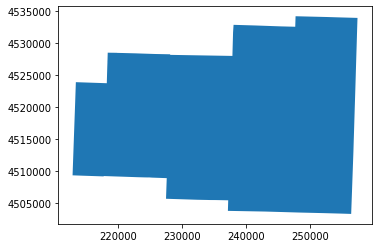

In [6]:
test_df=map_df[map_df.NAME=='4']
test_df.plot()

In [7]:
map_df = map_df[map_df.geometry.notnull()]
prec_df = prec_df[prec_df.geometry.notnull()]

NameError: name 'ptest_df' is not defined

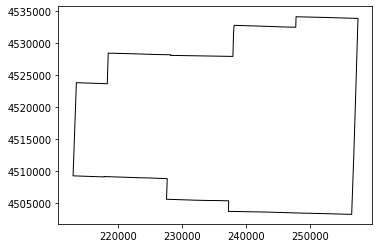

In [8]:
fig = Figure()
base = test_df.plot(color='white',edgecolor='black')
ptest_df.plot(ax=base, color='blue', figsize=(12, 12))
plt.xticks([])
plt.yticks([])

In [9]:
ptest_1=prec_df[prec_df.PRECINCT_e=='WOOSTER CITY 4-C']
ptest_2=prec_df[prec_df.PRECINCT_e=='WOOSTER CITY 3-C']
ptest_3=prec_df[prec_df.PRECINCT_e=='WOOSTER CITY 4-D']

([], <a list of 0 Text yticklabel objects>)

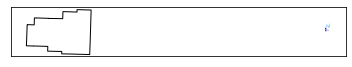

In [10]:
fig = Figure()
base = test_df.plot(color='white',edgecolor='black')
ptest_1.plot(ax=base, color='blue', figsize=(12, 12))
ptest_2.plot(ax=base, color='skyblue', figsize=(12, 12))
ptest_3.plot(ax=base, color='silver', figsize=(12, 12))
plt.xticks([])
plt.yticks([])

In [183]:
prec_df[(prec_df.PRECINCT_e==top_dict[key][0]) & (prec_df.county_nam=='Allen')]

,fid,PRECINCT,COUNTY,global_id,COUNTYGEOI,PRECINCT_e,PRECINCTCO,PRECINCT_m,county_nam,precinct_c,...,pres_16__3,pres_16_ev,pres_16_mo,pres_16__4,pres_16__5,pres_16_ji,pres_16__6,pres_16_do,pres_16__7,geometry
2610,2611.0,Jackson A,allen,3924.0,39003.0,JACKSON A,AEN,None,Allen,AEN,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,679.0,"POLYGON ((257108.6281311005 4522759.843866574,..."


4
['JACKSON A', 'AMANDA E', 'MARION A']
district_4.png


<Figure size 432x288 with 0 Axes>

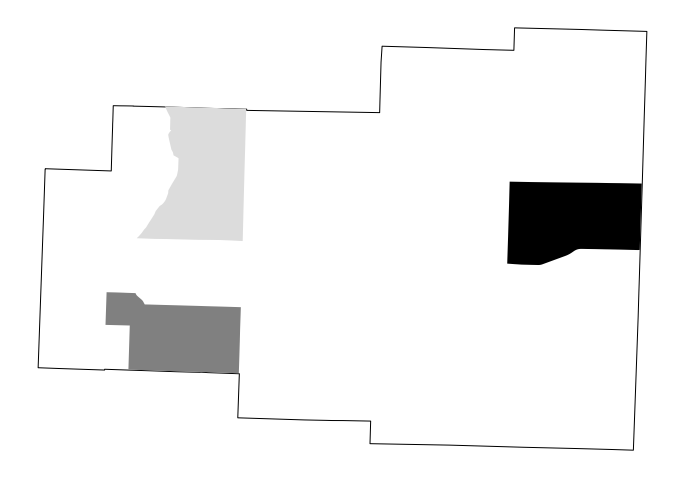

In [11]:
img_path='/Users/kristinalooper/WorkArea/insight/test_images/'
#for key in top_dict:
for key in range(4,5):
    print(key)
    plt.clf()
    print(top_dict[key])
    district_df=map_df[map_df.NAME==str(key)]
    if key == 4:
        precdf_0 = prec_df[(prec_df.PRECINCT_e==top_dict[key][0]) & (prec_df.county_nam=='Allen')]
    else:
        precdf_0=prec_df[prec_df.PRECINCT_e==top_dict[key][0]]
    precdf_1=prec_df[prec_df.PRECINCT_e==top_dict[key][1]]
    precdf_2=prec_df[prec_df.PRECINCT_e==top_dict[key][2]]
    base = district_df.plot(color='white',edgecolor='black',figsize=(12, 12))
    precdf_0.plot(ax=base, color='black', figsize=(12, 12))
    precdf_1.plot(ax=base, color='grey', figsize=(12, 12))
    precdf_2.plot(ax=base, color='gainsboro', figsize=(12, 12))
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    ax.axis('off')
    fname='district_'+str(key)+'.png'
    print(fname)
    plt.savefig(img_path+fname, transparent=True)

In [36]:
import contextily as ctx
import matplotlib.patches as mpatches

In [104]:
debug_dict=dict(zip(prec_df.PRECINCT_e,prec_df.PRECINCT_e))

In [308]:
#dictionary[new_key] = dictionary.pop(old_key)
#debug_dict['TWINSBURG TWP A'] = debug_dict.pop('TWINSBURG 5-B')
#debug_dict['WASHINGTON TWP G'] = debug_dict.pop('WASHINGTON-G')
#debug_dict['WASHINGTON TWP S'] = debug_dict.pop('WASHINGTON-S')
#debug_dict['HARRISON TWP L'] = debug_dict.pop('HARRISON-L')
#debug_dict['PRECINCT TOLEDO 12D'] = debug_dict.pop('TOLEDO 12D')
#debug_dict['PRECINCT TOLEDO 12B'] = debug_dict.pop('TOLEDO 12B')
#debug_dict['PRECINCT TOLEDO 5I'] = debug_dict.pop('TOLEDO 5I')
#debug_dict['PRECINCT TOLEDO 1D'] = debug_dict.pop('TOLEDO 1D')
#debug_dict['PRECINCT TOLEDO 3B'] = debug_dict.pop('TOLEDO 3B')
#debug_dict['PRECINCT TOLEDO 3H'] = debug_dict.pop('TOLEDO 3H')
#debug_dict['PRECINCT SPRINGFIELD 11'] = debug_dict.pop('SPRINGFIELD 11')
#debug_dict['PRECINCT OREGON 5'] = debug_dict.pop('OREGON 5')
#debug_dict['PRECINCT SPRINGFIELD 7'] = debug_dict.pop('SPRINGFIELD 7')
#debug_dict['PRECINCT MONCLOVA 2'] = debug_dict.pop('MONCLOVA 2')
#debug_dict['PRECINCT MONCLOVA 5'] = debug_dict.pop('MONCLOVA 5')
#debug_dict['PRECINCT SYLVANIA TOWNSHIP Q'] = debug_dict.pop('SYLVANIA TOWNSHIP Q')
#debug_dict['PRECINCT POT  2'] = debug_dict.pop('PRECINCT POT 2')
#debug_dict['PRECINCT CNT  3'] = debug_dict.pop('PRECINCT CNT 3')
#debug_dict['PRECINCT BVT  4'] = debug_dict.pop('PRECINCT BVT 4')
#debug_dict['PRECINCT HINCKLEY TP A'] = debug_dict.pop('HINCKLEY TP A')
#debug_dict['PRECINCT MEDINA CITY 2-A'] = debug_dict.pop('MEDINA CITY 2-A')
#debug_dict['PRECINCT MEDINA CITY 4-B'] = debug_dict.pop('MEDINA CITY 4-B')
#debug_dict['PRECINCT BAINBRIDGE TWP D'] = debug_dict.pop('009 BAINBRIDGE TWP D')
#debug_dict['PRECINCT BAINBRIDGE TWP A'] = debug_dict.pop('006 BAINBRIDGE TWP A1')
#debug_dict['PRECINCT TWIN TWP. GORDON & ITHACA'] = debug_dict.pop('PRECINCT TWIN TWP. GORDON &amp; ITHACA')
#debug_dict['SOUTHERN POINT'] = debug_dict.pop('PRECINCT SOUTHERN POINT')
#debug_dict['SCIOTO-SOUTH'] = debug_dict.pop('PRECINCT SCIOTO-SOUTH')
#debug_dict['PRECINCT CHARDON CITY D'] = debug_dict.pop('022 CHARDON CITY D')
#debug_dict['PRECINCT CHARDON CITY A'] = debug_dict.pop('019 CHARDON CITY A')
#debug_dict['PRECINCT LIVERPOOL TP B'] = debug_dict.pop('LIVERPOOL TP B')
#debug_dict['PRECINCT BRHILLS TP F'] = debug_dict.pop('BRHILLS TP F') 
#debug_dict['PRECINCT BRUNSWICK CITY 4-C'] = debug_dict.pop('BRUNSWICK CITY 4-C')
debug_dict['SANDUSKY-WHETSTONE NORTH'] = debug_dict.pop('WHETSTONE TWP NORTH')

1
['WOOSTER CITY 4-C', 'WOOSTER CITY 3-C', 'WOOSTER CITY 4-D']
2
['JEFF A', 'MAN 1 - E', 'MAN 1 - D']
3
['MIDDLETON TWP NORTH', 'PERRYSBURG X', 'BOWLING GREEN 3-E']
4
['JACKSON A', 'AMANDA E', 'MARION A']
5
['PRECINCT PERRY TWP NORTH', 'PRECINCT PERRY TWP SW', 'PRECINCT COLUMBIANA VIL D']
6
['BROADVIEW HEIGHTS-04-A', 'SOLON-05-A', 'SOLON-06-B']
7
['OLMSTED TOWNSHIP-00-G', 'STRONGSVILLE-01-F', 'STRONGSVILLE-03-D']
8
['EUCLID-01-D', 'BEACHWOOD-00-H', 'BEACHWOOD-00-F']
9
['SHAKER HEIGHTS-00-U', 'SHAKER HEIGHTS-00-J', 'SHAKER HEIGHTS-00-O']
10
['CLEVELAND-03-L', 'BRATENAHL-00-A', 'CLEVELAND-03-D']
11
['GARFIELD HEIGHTS-05-B', 'GARFIELD HEIGHTS-07-C', 'GARFIELD HEIGHTS-05-A']
12
['WARRENSVILLE HTS-03-A', 'BEDFORD-06-A', 'BEDFORD HEIGHTS-03-B']
13
['LAKEWOOD-01-H', 'LAKEWOOD-04-B', 'LAKEWOOD-04-D']
14
['MIDDLEBURG HEIGHTS-01-A', 'MIDDLEBURG HEIGHTS-04-A', 'MIDDLEBURG HEIGHTS-04-B']
15
['BROOKLYN HEIGHTS-00-A', 'PARMA-05-A', 'PARMA-02-E']
16
['NORTH OLMSTED-01-A', 'ROCKY RIVER-04-D', 'WESTLAK

<Figure size 432x288 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

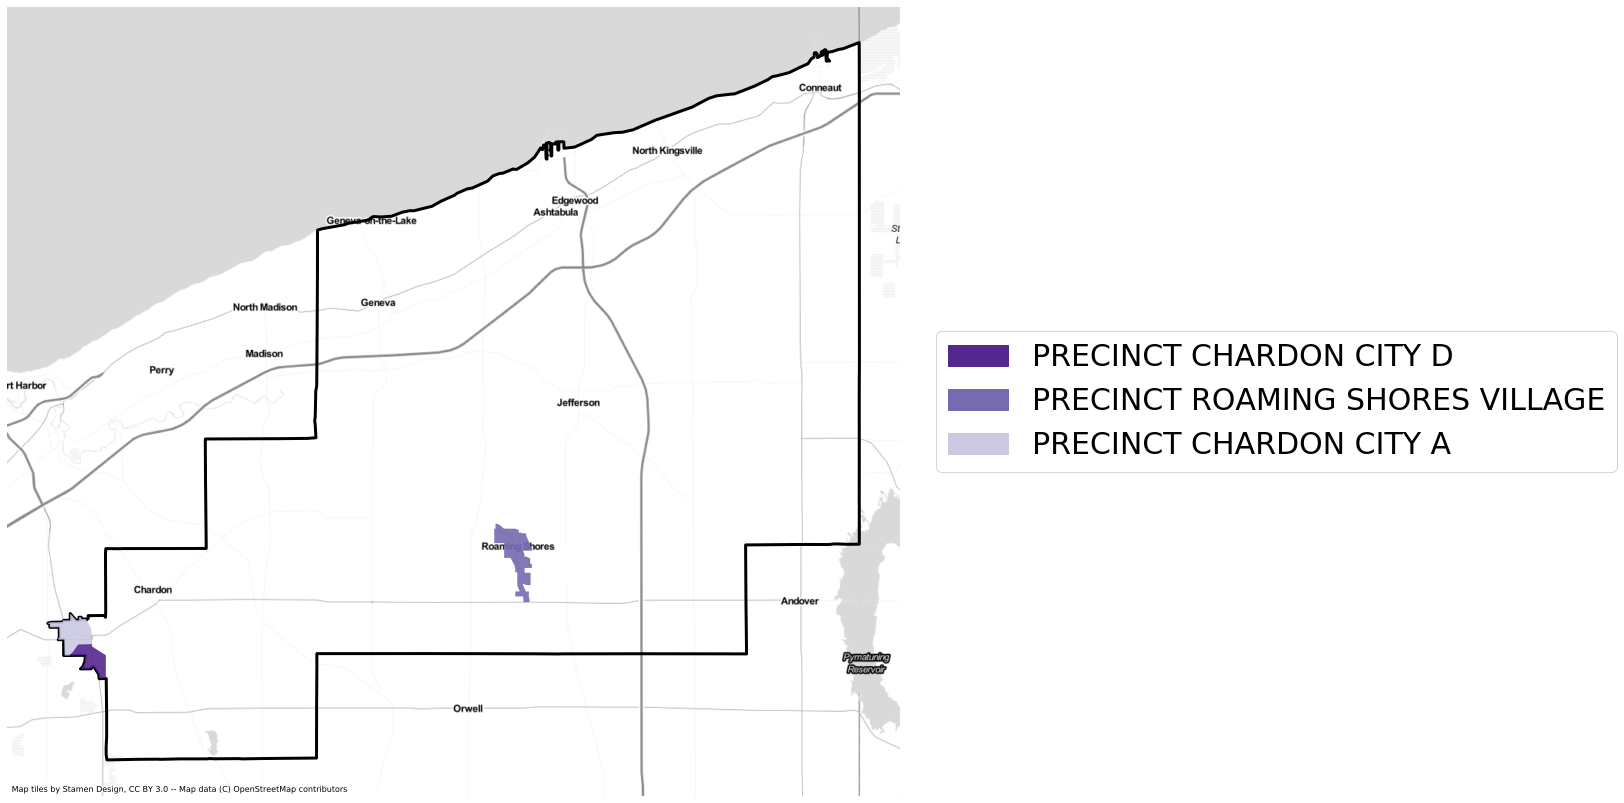

In [310]:
img_path='/Users/kristinalooper/WorkArea/insight/test_images/'
map_df_proj = map_df.to_crs(epsg=3857)
prec_df_proj = prec_df.to_crs(epsg=3857)
for key in top_dict:
    print(key)
    plt.clf()
    print(top_dict[key])
    preckey_0=debug_dict[top_dict[key][0]]
    preckey_1=debug_dict[top_dict[key][1]]
    if key != 73:
        preckey_2=debug_dict[top_dict[key][2]]
    if preckey_0 == 'PLAIN 19':
        preckey_0 = 'PLAIN 20' #off-by-one error in shape file, checked with map
    if key == 90 and preckey_0 == 'LIBERTY TOWNSHIP':
        preckey_0 = 'LIBERTY NORTH' #Shapefile name error
    if preckey_2 == 'PRECINCT MECHANIC TOWNSHIP':
        preckey_2 = 'PRECINCT KILLBUCK TOWNSHIP' #obvious mapping issue in shapefile
    district_df=map_df_proj[map_df_proj.NAME==str(key)]
    if key == 4:
        precdf_0 = prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_0) & (prec_df_proj.county_nam=='Allen')]
    elif key == 83:
        precdf_0 = prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_0) & (prec_df_proj.county_nam=='Hancock')]
    elif key == 85:
        precdf_0 = prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_0) & (prec_df_proj.county_nam=='Logan')]
    elif key == 98:
        precdf_0 = prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_0) & (prec_df_proj.county_nam=='Tuscarawas')]
    else:
        precdf_0=prec_df_proj[prec_df_proj.PRECINCT_e==preckey_0]
    if key == 72:
        precdf_1=prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_1) & (prec_df_proj.county_nam=='Licking')]
    elif key == 81:
        precdf_1=prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_1) & (prec_df_proj.county_nam=='Williams')]
    elif key == 82:
        precdf_1=prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_1) & (prec_df_proj.county_nam=='Paulding')]
    elif key == 83:
        precdf_1=prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_1) & (prec_df_proj.county_nam=='Hancock')]
    elif key == 84:
        precdf_1=prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_1) & (prec_df_proj.county_nam=='Auglaize')]
    elif key == 93:
        precdf_1=prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_1) & (prec_df_proj.county_nam=='Gallia')]
    elif key == 96:
        precdf_1=prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_1) & (prec_df_proj.county_nam=='Jefferson')]
    else:
        precdf_1=prec_df_proj[prec_df_proj.PRECINCT_e==preckey_1]
    if key == 42:
        precdf_2=prec_df_proj[(prec_df_proj.PRECINCT_e=='WASHINGTON-A') & (prec_df_proj.county_nam=='Montgomery')]
    elif key == 66:
        precdf_2=prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_2) & (prec_df_proj.county_nam=='Brown')]
    elif key == 68:
        precdf_2=prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_2) & (prec_df_proj.county_nam=='Knox')]
    elif key == 84:
        precdf_2=prec_df_proj[(prec_df_proj.PRECINCT_e==preckey_2) & (prec_df_proj.county_nam=='Darke')]
    else:
        precdf_2=prec_df_proj[prec_df_proj.PRECINCT_e==preckey_2]
    base = district_df.plot(facecolor='None',edgecolor='black', linewidth=3.0,figsize=(16, 16))
    ax = precdf_0.plot(ax=base, color='#54278f', alpha=0.90, figsize=(16, 16))
    ax = precdf_1.plot(ax=base, color='#756bb1', alpha=0.90, figsize=(16, 16))
    if key != 73:
        ax = precdf_2.plot(ax=base, color='#cbc9e2', alpha = 0.90, figsize=(16, 16))
    ctx.add_basemap(ax,url=ctx.providers.Stamen.TonerLite)
    plt.xticks([])
    plt.yticks([])
    ax.axis('off')
    black_patch = mpatches.Patch(color='#54278f', label=top_dict[key][0])
    grey_patch = mpatches.Patch(color='#756bb1',label=top_dict[key][1])
    light_patch= mpatches.Patch(color='#cbc9e2',label=top_dict[key][2])
    legend = plt.legend(handles=[black_patch,grey_patch,light_patch], prop={'size': 30},bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    fname='district_'+str(key)+'.png'
    plt.savefig(img_path+fname, transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

In [306]:
for key in range(37,38):
    print(top_dict[key][2])
    print(prec_df_proj[prec_df_proj.PRECINCT_e=='SANDUSKY-WHETSTONE NORTH'])

TWINSBURG TWP A
Empty GeoDataFrame
Columns: [fid, PRECINCT, COUNTY, global_id, COUNTYGEOI, PRECINCT_e, PRECINCTCO, PRECINCT_m, county_nam, precinct_c, region_nam, media_mark, pres_16_re, pres_16_to, pres_16_tu, pres_16_ja, pres_16_mi, pres_16_da, pres_16_hi, pres_16_ri, pres_16_ch, pres_16_be, pres_16__1, pres_16_br, pres_16_ga, pres_16__2, pres_16_ba, pres_16_la, pres_16_jo, pres_16__3, pres_16_ev, pres_16_mo, pres_16__4, pres_16__5, pres_16_ji, pres_16__6, pres_16_do, pres_16__7, geometry]
Index: []

[0 rows x 39 columns]


In [86]:
prec_df_proj.head()

,fid,PRECINCT,COUNTY,global_id,COUNTYGEOI,PRECINCT_e,PRECINCTCO,PRECINCT_m,county_nam,precinct_c,...,pres_16__3,pres_16_ev,pres_16_mo,pres_16__4,pres_16__5,pres_16_ji,pres_16__6,pres_16_do,pres_16__7,geometry
0,1.0,GALLIPOLIS CITY 1,gallia,4179.0,39053.0,GALLIPOLIS CITY 1,AAA,None,Gallia,AAA,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,267.0,POLYGON ((-9152524.002862403 4695016.148530925...
1,2.0,GALLIPOLIS CITY 3,gallia,4180.0,39053.0,GALLIPOLIS CITY 3,AAB,None,Gallia,AAB,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,449.0,POLYGON ((-9145427.719258998 4698440.078241647...
2,3.0,GALLIPOLIS CITY 2,gallia,4181.0,39053.0,GALLIPOLIS CITY 2,AAE,None,Gallia,AAE,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,247.0,POLYGON ((-9150643.816565091 4695971.823741222...
3,4.0,ADDISON TOWNSHIP,gallia,4182.0,39053.0,ADDISON TWP,AAG,None,Gallia,AAG,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,752.0,POLYGON ((-9146257.383458333 4711966.598681379...
4,5.0,CHESHIRE TOWNSHIP,gallia,4183.0,39053.0,CHESHIRE TWP,AAI,None,Gallia,AAI,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,330.0,POLYGON ((-9152391.198611351 4712299.322014051...


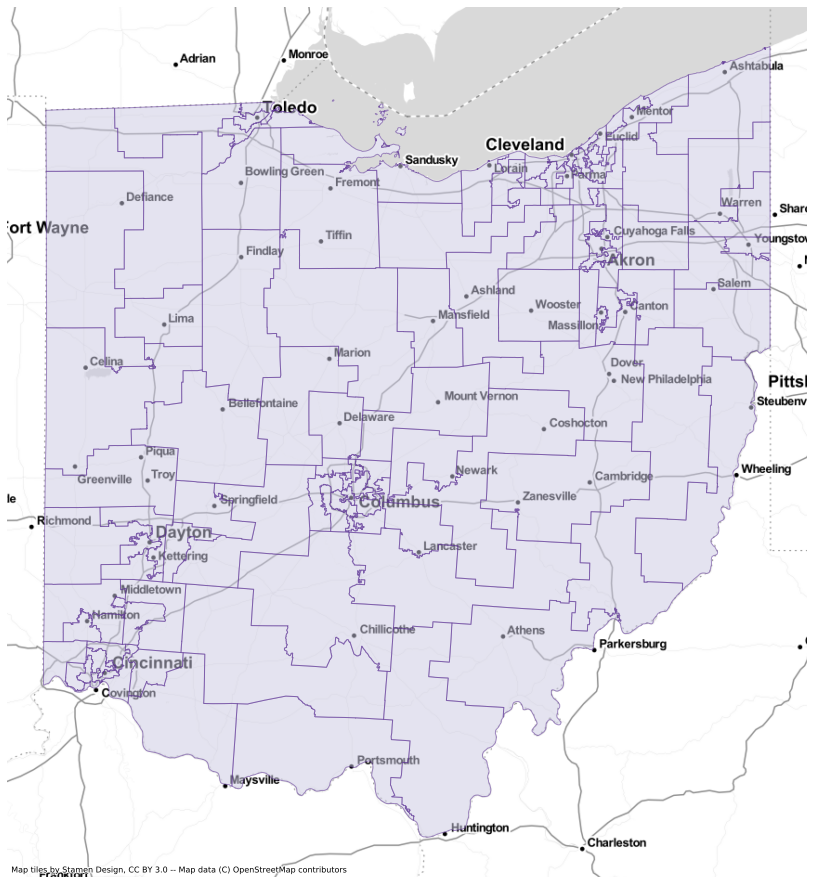

In [314]:
fp = "/Volumes/FileStorage/Insight_data/cb_2018_39_sldl_500k/cb_2018_39_sldl_500k.shp"
fig = Figure()
oh_map_df = gpd.read_file(fp)
oh_map_proj=oh_map_df.to_crs(epsg=3857)
ax = oh_map_proj.plot(color='#cbc9e2', edgecolor='#54278f', alpha=0.5, figsize=(16, 16))
ctx.add_basemap(ax,url=ctx.providers.Stamen.TonerLite)
plt.xticks([])
plt.yticks([])
ax.axis('off')
fname='ohio_with_map.png'
plt.savefig(img_path+fname, transparent=True)